In [8]:
import re

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)

from collections import Counter, defaultdict
from wordcloud import WordCloud

from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats

from dunn import kw_dunn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})

import statsmodels.api as sm
import statsmodels.formula.api as smf

from os.path import basename
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from datetime import datetime

### Parameters:

In [2]:
races = sorted(['caucasian', 'african', 'latino', 'eastasian', 'asianindian', 'other'])
races

['african', 'asianindian', 'caucasian', 'eastasian', 'latino', 'other']

In [3]:
# Pick columns here
columns = "power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig".split(",")

In [4]:
# Pick statistical alpha here
alpha = 0.01

# LIWC Analysis

## Loading data

In [5]:
data = pd.read_csv("../data/LIWC2015 Results (preprocessed.csv).csv", sep = "\t")\
         .rename(columns = {'A': 'channel', 'B': 'show', 'C':'filename', 'D':'speaker', 'E':'gender', 'F':'race', 'G':'dialogue'})

data.loc[data['gender'] == 'N.A', 'gender'] = np.nan    
data.loc[data['race'] == 'N.A', 'race'] = np.nan   

# Remove unknown genders and nans
data = data[data['gender'].isin(['female', 'male'])]

# Make gender binary (this might piss someone off)
data['gender'] = (data['gender'] == 'female').astype(int)

data.head()

,channel,show,filename,speaker,gender,race,dialogue,WC,Analytic,Clout,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,DON LEMON ( CNN TONIGHT NEWS SHOW HOST),0,"african,caucasian",This is CNN tonight. I'm Don Lemon. 11:00 p....,157,93.43,55.06,...,0.00,0.64,0.0,0.0,0.0,0.64,0.00,1.91,0.0,0.0
1,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,KAITLAN COLLINS ( CNN WHITE HOUSE CORRESPONDENT),1,caucasian,Well there are a lot of questions about whethe...,207,84.52,78.03,...,1.45,0.00,0.0,0.0,0.0,0.48,0.97,0.00,0.0,0.0
2,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,LEMON,0,caucasian,"Jack Kingston, do you think Chief of Staff Kel...",12,80.75,95.20,...,8.33,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
3,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,JACK KINGSTON ( FORMER U.S. REPRESENTATIVE),0,caucasian,I think that he should try to stay on. But I ...,136,13.36,38.42,...,4.41,0.00,0.0,0.0,0.0,0.00,0.00,5.15,0.0,0.0
4,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,LEMON,0,caucasian,Bakari explain why you say John Kelly has take...,16,97.17,99.00,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0


In [21]:
# Check dates of data
data['date'] = data['filename'].apply(basename).apply(lambda x: re.findall(r"(\d{4})-(\d{2})-(\d{2}).*", x)[0]).apply(lambda x: tuple(map(int, x))).apply(lambda x: datetime(*x))

In [22]:
data = data[(data['date'] > '2018-01-28') & (data['date'] <= '2018-02-10')]

In [23]:
data.shape

(7876, 101)

In [25]:
data.filename.unique()

array(['../data/output_clean/CNN/Erin_Burnett_OutFront/2018-01-29.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-08.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-09.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-07.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-06.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-05.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-02-01.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-01-30.txt',
       '../data/output_clean/CNN/Erin_Burnett_OutFront/2018-01-31.txt',
       '../data/output_clean/FOX/Hannity/2018-02-08.txt',
       '../data/output_clean/FOX/Hannity/2018-02-09.txt',
       '../data/output_clean/FOX/Hannity/2018-02-07.txt',
       '../data/output_clean/FOX/Hannity/2018-02-06.txt',
       '../data/output_clean/FOX/Hannity/2018-02-05.txt',
       '../data/output_clean/FOX/Hannity/2018-02-01.txt',
    

Manually fix some races

In [26]:
data.loc[data['speaker']=='HANNITY', 'race'] = 'caucasian'
data.loc[data['speaker']=='UNIDENTIFIED MALE', 'race'] = np.nan
data.loc[data['speaker']=='UNIDENTIFIED FEMALE', 'race'] = np.nan
data.loc[data['speaker'] == 'GUTFELD', 'race'] = 'caucasian' #Gutfeld is 37.5% Irish, 25% Ashkenazi Jewish, 18.75% French, 12.5% German, 6.25% Mexican (ethnicelebs)
data.loc[data['speaker'] == 'LOWRY', 'race'] = 'caucasian' #https://edition.cnn.com/profiles/brian-lowry (by looks)
data.loc[data['speaker'] == 'MOOS', 'race'] = 'caucasian' #https://edition.cnn.com/profiles/jeanne-moos-profile (by looks)

In [27]:
data['gender'].unique()

array([0, 1])

In [28]:
data['race'].unique()

array(['caucasian', 'latino,caucasian', 'african', nan,
       'african,caucasian', 'asianindian',
       'nativeamerican,caucasian,eastasian',
       'eastasian,pacificislander,caucasian', 'latino,african', 'latino',
       'eastasian', 'nativeamerican,caucasian', 'eastasian,caucasian',
       'asianindian,caucasian', 'african,eastasian', 'other,caucasian',
       'african,asianindian,eastasian,latino,caucasian',
       'nativeamerican,asianindian,african', 'other',
       'asianindian,african', 'nativeamerican,latino,african',
       'nativeamerican,pacificislander,african,caucasian',
       'eastasian,latino,caucasian', 'pacificislander,caucasian',
       'other,african', 'other,latino,caucasian',
       'african,latino,caucasian', 'caucasian,eastasian', 'other,latino',
       'nativeamerican,eastasian,caucasian', 'caucasian,latino,eastasian',
       'nativeamerican,african,caucasian'], dtype=object)

## Descriptive Analytics
* Number of dialogues per channel:

In [29]:
data.groupby("channel").agg({"filename":len})

,filename
channel,
CNN,1400
FOX,4648
MSNBC,1828


* Number of dialogues per show:

In [30]:
data.groupby(["channel", "show"]).agg({"filename":len})

filename
channel show                                          
CNN     Erin_Burnett_OutFront                     1400
FOX     Hannity                                    882
        The_Five                                  2184
        The_Ingraham_Angle                         754
        The_Story                                  828
MSNBC   All_In_with_Chris_Hayes                    757
        The_Beat_with_Ari_Melber                   637
        The_Last_Word_with_Lawrence_ODonnell       159
        The_Rachel_Maddow_Show                     275

* Female - Male distribution per channel per show:

In [31]:
data.groupby(["channel", "show", "gender"]).agg({"filename":len})

filename
channel show                                 gender          
CNN     Erin_Burnett_OutFront                0           1164
                                             1            236
FOX     Hannity                              0            769
                                             1            113
        The_Five                             0           1161
                                             1           1023
        The_Ingraham_Angle                   0            679
                                             1             75
        The_Story                            0            739
                                             1             89
MSNBC   All_In_with_Chris_Hayes              0            674
                                             1             83
        The_Beat_with_Ari_Melber             0            558
                                             1             79
        The_Last_Word_with_Lawrence_ODonnell 0            135
                                             1             24
        The_Rachel_Maddow_Show               0            103
                                             1            172

* Race distribution per channel:

In [32]:
d = data.groupby(['channel']).agg({'race':lambda x: Counter(x)}).apply({'race':pd.Series})
d.loc[:, d.columns.get_level_values(1).isin(races)]

race                                             
        african caucasian asianindian latino eastasian other
channel                                                     
CNN        62.0    1130.0         4.0    9.0       8.0   NaN
FOX      1056.0    2470.0        40.0  475.0      45.0  57.0
MSNBC      73.0    1250.0         NaN   14.0      11.0   1.0

 * Race distribution per channel per show:

In [33]:
d = data.groupby(['channel', 'show']).agg({'race':lambda x: Counter(x)}).apply({'race':pd.Series})
d.loc[:, d.columns.get_level_values(1).isin(races)]

race                        \
                                             african caucasian asianindian   
channel show                                                                 
CNN     Erin_Burnett_OutFront                   62.0    1130.0         4.0   
FOX     Hannity                                 20.0     650.0         NaN   
        The_Five                               635.0    1284.0        38.0   
        The_Ingraham_Angle                     362.0     208.0         NaN   
        The_Story                               39.0     328.0         2.0   
MSNBC   All_In_with_Chris_Hayes                 11.0     660.0         NaN   
        The_Beat_with_Ari_Melber                53.0     204.0         NaN   
        The_Last_Word_with_Lawrence_ODonnell     5.0     141.0         NaN   
        The_Rachel_Maddow_Show                   4.0     245.0         NaN   

                                                                     
                                             latino eastasian other  
channel show                                                         
CNN     Erin_Burnett_OutFront                   9.0       8.0   NaN  
FOX     Hannity                                74.0       7.0  13.0  
        The_Five                                2.0       3.0   NaN  
        The_Ingraham_Angle                     19.0      28.0  41.0  
        The_Story                             380.0       7.0   3.0  
MSNBC   All_In_with_Chris_Hayes                 3.0       NaN   NaN  
        The_Beat_with_Ari_Melber               10.0       1.0   1.0  
        The_Last_Word_with_Lawrence_ODonnell    NaN       NaN   NaN  
        The_Rachel_Maddow_Show                  1.0      10.0   NaN

## Statistical analysis

### Gender

In [34]:
data[['channel', 'show', 'speaker', 'gender'] + columns].head()

,channel,show,speaker,gender,power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig
8311,CNN,Erin_Burnett_OutFront,"ADAM SCHIFF ( RANKING MEMBER, INTELLIGENCE CO...",0,8.22,83.12,0.0,0.0,8.22,2.74,68.64,0.0,0.0
8312,CNN,Erin_Burnett_OutFront,BURNETT,0,1.15,75.49,0.0,0.0,0.00,0.00,68.40,0.0,0.0
8313,CNN,Erin_Burnett_OutFront,TREY GOWDY ( JUDICIARY COMMITTEE),0,0.00,87.57,0.0,0.0,0.00,0.00,15.66,0.0,0.0
8314,CNN,Erin_Burnett_OutFront,BURNETT,0,0.00,50.00,0.0,0.0,100.00,0.00,92.84,0.0,0.0
8315,CNN,Erin_Burnett_OutFront,GOWDY,0,0.00,82.58,0.0,0.0,6.25,3.12,1.00,0.0,0.0



We would like to compare channels (i.e., CNN v. FOX). But...
How to aggregate different shows?

* We could take the average... but longer shows would have more weight on the metrics.
* We could do partial corr between gender and LIWC metrics, controlling for show... (_This seems like the more reasonable thing to do_)


#### Partial correlation between gender and LIWC
Women use more words related to Family (as seen countless times before); Men use more words related to Clout and Sexual.

In [35]:
# Partial correlations
model = smf.ols('gender ~ channel + show', data = data).fit()
resid_gender = model.resid

for c in columns:
    model = smf.ols(f'{c} ~ channel + show', data = data).fit()
    resid_power = model.resid

    rho, p = stats.pearsonr(resid_power, resid_gender)
    print("{} {} {}{}".format(c, rho, p, '' if p > 0.05 else '*' if p > 0.01 else '**' if p > 0.005 else '***'))

power 0.001064168784328209 0.9247702515109637
Clout -0.037556706873487326 0.0008570343089192335***
family 0.01665133392572923 0.13950925063315922
sexual -0.026766514281571122 0.017525579194036644*
posemo -0.0013309976830206704 0.9059859432980972
negemo -0.0002018588170764579 0.9857094651061623
Analytic -0.007185143414242126 0.5237564121012691
swear 0.0016822497010635152 0.8813400033219059
relig 0.012525086102314974 0.266383794782139


#### Differences between channels

In [36]:
for ch in data.channel.unique():
    tests = []
    ch_data = data[data.channel == ch]
    
    for c in columns:
        model = smf.ols(f'{c} ~ show', data = ch_data).fit() #Control for show and race
        resid_power = model.resid
        
        
        mv = model.resid[ch_data.gender == 0]
        fv = model.resid[ch_data.gender == 1]
        test = stats.mannwhitneyu(mv, fv, alternative='greater')
        
        tests.append((c, *test))

    ###########################
    # HolmBonferroni correction
    ###########################
    n = len(tests)

    #  order by p-val
    tests = sorted(tests, key = lambda x: x[2])
    
    print(f"Channel: {ch}")
    # hb formula for first rank
    rank = 1
    while rank < n + 1:
        hb = alpha / (n - rank + 1)
        if tests[rank - 1][2] < hb:
            print(f"\t{tests[rank - 1]}")
            rank += 1
        else:
            break
    print()

Channel: CNN

Channel: FOX
	('swear', 3139026.0, 5.2340396186741909e-138)
	('sexual', 3135641.0, 9.1947109995103953e-137)
	('relig', 3089619.5, 1.0093074251431982e-123)
	('family', 3071807.0, 5.1333461367375714e-118)
	('posemo', 2617321.0, 6.4273362502207011e-28)

Channel: MSNBC
	('sexual', 348109.5, 3.2903929502248989e-24)
	('swear', 347818.5, 4.8682355293309334e-24)
	('posemo', 310526.5, 5.2984668910403328e-08)



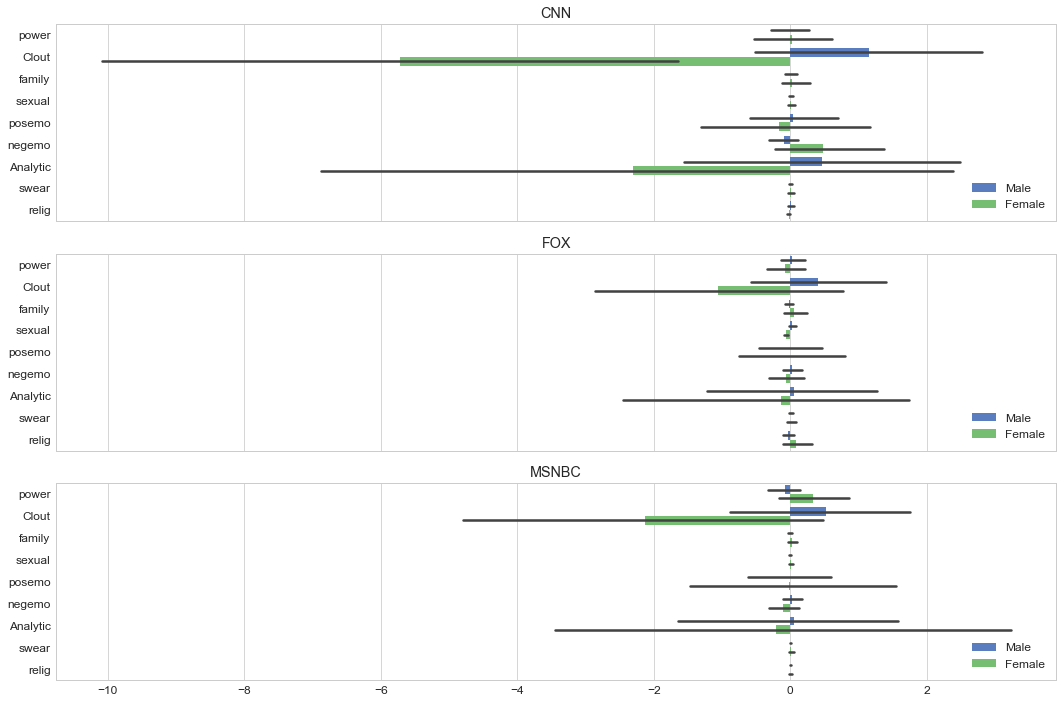

In [37]:
sns.set_context('paper', font_scale = 1.5)
sns.set_style("whitegrid")

fig, ax = plt.subplots(3, sharex=True)

for i, ch in enumerate(data.channel.unique()):
    ch_data = data[data['channel'] == ch].copy()
    for c in columns:
        model = smf.ols(f"{c} ~ show", data = ch_data).fit()
        resid_power = model.resid
        ch_data[c] = resid_power
    
    melt = ch_data.melt(id_vars=['gender'], value_vars=columns)
    melt.loc[melt['gender'] == 0, 'gender'] = 'Male'
    melt.loc[melt['gender'] == 1, 'gender'] = 'Female'
    sns.barplot(x = 'value', y = 'variable', hue = 'gender', data = melt, palette='muted', ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_title(ch)
    ax[i].set_ylabel("")
    ax[i].legend(loc='lower right')
    
    
plt.tight_layout()
# plt.savefig("liwc_graph_1_500.eps", bbox_inches='tight', dpi=500)
plt.show()
    

### Race

In [38]:
data[['channel', 'show', 'speaker', 'race'] + columns].head()

,channel,show,speaker,race,power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig
8311,CNN,Erin_Burnett_OutFront,"ADAM SCHIFF ( RANKING MEMBER, INTELLIGENCE CO...",caucasian,8.22,83.12,0.0,0.0,8.22,2.74,68.64,0.0,0.0
8312,CNN,Erin_Burnett_OutFront,BURNETT,caucasian,1.15,75.49,0.0,0.0,0.00,0.00,68.40,0.0,0.0
8313,CNN,Erin_Burnett_OutFront,TREY GOWDY ( JUDICIARY COMMITTEE),caucasian,0.00,87.57,0.0,0.0,0.00,0.00,15.66,0.0,0.0
8314,CNN,Erin_Burnett_OutFront,BURNETT,caucasian,0.00,50.00,0.0,0.0,100.00,0.00,92.84,0.0,0.0
8315,CNN,Erin_Burnett_OutFront,GOWDY,caucasian,0.00,82.58,0.0,0.0,6.25,3.12,1.00,0.0,0.0


In [39]:
len(data['speaker'].unique())

976

#### Most popular characters w/ ethnicity

In [40]:
d = data.groupby('speaker').agg({'filename':len, 'show':lambda x: "{:.2f}%".format(100 * len(x) / len(data)), 'race':lambda x: set(x)}).sort_values(by = 'show', ascending = False).head(30)
d

,filename,show,race
speaker,,,
BURNETT,551,7.00%,{caucasian}
WATTERS,476,6.04%,{caucasian}
HANNITY,382,4.85%,{caucasian}
GUILFOYLE,374,4.75%,{caucasian}
HAYES,370,4.70%,{caucasian}
MACCALLUM,339,4.30%,{latino}
PERINO,324,4.11%,{african}
WILLIAMS,322,4.09%,{african}
GUTFELD,309,3.92%,{caucasian}


First 30 persons capture 55.63% of the dialogues in the dataset

In [41]:
print("Total Dialogues\tPercentage")
print(f"{d['filename'].sum()}\t\t{d['show'].apply(lambda x:float(x[:-1])).sum():.2f}%")

Total Dialogues	Percentage
5369		68.14%


##### Statistical tests

First, we check for homeocedasticity between groups. If this test fails (Ho is rejected) then we perform Kruskal-Wallis test, otherwise we do ANOVA.

In [42]:
for ch in data.channel.unique():
    tests = []
    
    for c in columns:
            
        ch_data = data[data.channel == ch]

        # Remove effect of show and gender
        model = smf.ols(f'{c} ~ show + gender', data = ch_data).fit()
        res = model.resid
        
        groups = [res[ch_data.race == r].values for r in races]
        
        # TODO: Update this p to use Holm-Bonferroni correction
        levene_p = stats.levene(*groups).pvalue
        
        if levene_p < alpha:
            # Reject: Groups have different variances
            # Use Krukal-Wallis
            tests.append((c, "KW", stats.mstats.kruskalwallis(*groups)))
            
        else:
            # Cannot reject, assume groups have same variances
            # Use ANOVA
            tests.append((c, "A", stats.f_oneway(*groups)))
        
    ###########################
    # HolmBonferroni correction
    ###########################
    n = len(tests)

    #  order by p-val
    tests = sorted(tests, key = lambda x: x[2].pvalue)
    
    print(f"Channel: {ch}")
    # hb formula for first rank
    rank = 1
    while rank < n + 1:
        hb = alpha / (n - rank + 1)
        if tests[rank - 1][2].pvalue < hb:
            print(f"\t{tests[rank - 1]}")
            rank += 1
        else:
            break
    print()
        
        

/home/victor/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/victor/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


Channel: CNN

Channel: FOX
	('family', 'KW', KruskalResult(statistic=851.13097672396555, pvalue=1.0013824687131117e-181))

Channel: MSNBC



In [ ]:
##### TODO: Tukey tests